In [1]:
import pybaseball
import pandas as pd
import numpy as np
import bs4
import requests
import matplotlib.pyplot as plt
import unicodedata
import seaborn as sns
import math
import matplotlib.patches as mpatches
from IPython.display import display
pybaseball.cache.enable()

In [2]:
import os
pd.set_option('display.max_columns',None)
os.getcwd()
os.chdir('C:\\Users\\npacchioli\\Desktop\\pyBaseball\\')
os.getcwd()

directory = 'C:\\Users\\npacchioli\\Desktop\\pyBaseball\\'

In [3]:
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher
from pybaseball import statcast_batter
from pybaseball import statcast
from pybaseball import pitching_stats

In [19]:
#get raw data for all pitchers

raw = statcast('2023-03-30','2023-07-26')

This is a large query, it may take a moment to complete


100%|██████████| 119/119 [00:26<00:00,  4.55it/s]


In [20]:
raw = raw.sort_values(by=['game_date', 'inning','at_bat_number','pitch_number'], ascending = [True, True,True,True])

In [21]:
raw = raw.dropna(subset=['release_speed','pfx_z'])

In [22]:
#create all the variables needed to calculate VAA

yO = 50
yf = 17/12
yFin = yO - yf

#first create vy_)

raw['vy_f'] = -np.sqrt((raw['vy0']**2) - (2* raw['ay']*yFin))
raw['t'] = (raw['vy_f'] - raw['vy0']) / raw['ay']
raw['vz_f'] = raw['vz0'] + (raw['az']*raw['t'])
raw['vaa'] = (np.arctan(raw['vz_f']/raw['vy_f'])*-1)*(180/np.pi)

In [23]:
raw['pfx_z'] = raw['pfx_z']*12
raw['pfx_x'] = raw['pfx_x']*12

#raw = raw.dropna(subset=['release_speed'])
#raw[['release_speed']] = raw[['release_speed']].astype('int64')

raw = raw.dropna(subset=['release_spin_rate'])
raw[['release_spin_rate']] = raw[['release_spin_rate']].astype('int64')

raw = raw.dropna(subset=['spin_axis'])
raw[['spin_axis']] = raw[['spin_axis']].astype('int64')



In [24]:
#let's create average fastball speed, to then compare to the breaking pitch
fastballs = raw.loc[raw['pitch_type'] == 'FF']

In [25]:
fastballs.describe()

,release_speed,release_pos_x,release_pos_z,batter,pitcher,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,spin_axis,delta_home_win_exp,delta_run_exp,vy_f,t,vz_f,vaa
count,145315.0,145315.0,145315.0,145315.0,145315.0,0.0,0.0,0.0,0.0,145315.0,29935.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,13375.0,25598.0,42968.0,145315.0,145315.0,23417.0,23417.0,0.0,0.0,145315.0,0.0,0.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,51386.0,51139.0,51165.0,145290.0,145315.000000,145267.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,23374.0,23374.0,35822.0,35773.0,35822.0,35822.0,23374.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.0,145315.000000,145315.0,145312.0,145315.0,145315.0,145315.0,145315.0
mean,94.142025,-0.826328,5.834473,628854.492757,628203.800908,<NA>,<NA>,<NA>,<NA>,7.932725,5.341072,0.943454,0.867591,2023.0,-3.255522,15.842825,-0.012226,2.813182,631143.88015,631510.676772,629742.994368,0.962908,4.819303,129.060461,115.540096,<NA>,<NA>,617872.836968,<NA>,<NA>,2.759992,-136.884634,-5.080106,-4.128098,30.053078,-14.610841,3.360395,1.598009,189.161931,83.69946,28.127939,94.458237,2285.326050,6.516426,718012.785143,628203.800908,617872.836968,615442.324488,637564.728934,623139.177449,636467.895757,642136.211258,650121.779424,635928.298166,53.983718,0.340199,0.404662,0.355343,0.994996,0.186785,0.167523,3.415718,37.516306,2.940921,2.167677,2.364023,2.19585,2.33585,2.378956,2.182947,2.226054,2.33585,194.250986,0.000205,0.000933,-125.773497,0.370191,-10.500349,-4.773159
std,2.485077,1.779561,0.493213,56889.025522,56736.87664,<NA>,<NA>,<NA>,<NA>,4.25901,2.709589,1.024375,0.834418,0.0,7.905628,2.920424,0.746968,0.839198,56017.238932,56102.090129,56531.290099,0.822551,2.64644,42.963621,41.623909,<NA>,<NA>,57992.033934,<NA>,<NA>,6.192058,3.595023,2.701963,9.485577,2.837462,3.5267,0.189831,0.110188,106.25071,13.574327,28.073669,3.154413,167.524778,0.453619,443.677353,56736.87664,57992.033934,66976.598077,47726.402617,53810.808181,46003.586025,50994.72307,39180.496764,46249.139815,0.452605,0.302576,0.426571,0.531968,0.070561,0.389744,0.609879,1.30606,23.100379,1.76317,2.532607,2.691661,2.508477,2.715909,2.697372,2.539005,2.521782,2.715909,32.829065,0.02768,0.240699,3.346255,0.009759,2.238444,1.01746
min,70.4,-4.61,1.17,408234.0,425794.0,<NA>,<NA>,<NA>,<NA>,1.0,1.0,0.0,0.0,2023.0,-21.72,-9.48,-4.04,-3.49,408234.0,408234.0,408234.0,0.0,1.0,4.66,12.04,<NA>,<NA>,444489.0,<NA>,<NA>,-20.9275,-152.332093,-20.037189,-24.357848,12.077842,-41.04585,2.51,0.8,0.0,3.6,-86.0,0.0,239.000000,4.0,717239.0,425794.0,444489.0,456781.0,456781.0,446334.0,462101.0,444482.0,502054.0,444482.0,48.76,0.001,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,-0.776,-1.239,-140.892332,0.331426,-25.377693,-11.918957
25%,92.6,-2.11,5.56,605113.0,605182.0,<NA>,<NA>,<NA>,<NA>,4.0,2.0,0.0,0.0,2023.0,-9.12,14.16,-0.51,2.25,605170.0,606132.0,605113.0,0.0,2.0,101.23,82.92,<NA>,<NA>,572287.0,<NA>,<NA>,-2.455445,-139.223937,-6.863945,-11.148849,28.194937,-16.643725,3.23,1.52,123.0,74.7,12.0,92.7,2178.000000,6.2,717626.0,605182.0,572287.0,571976.0,622110.0,593643.0,607208.0,621493.0,642350.0,606132.0,53.69,0.069,0.07225,0.0,1.0,0.

In [26]:
#find bins for vertical release position
5.84 - .57 #5.27
5.27 - .57 #4.69
5.84 + .57 #6.41
6.41 + .57 #6.98

6.98

In [27]:
rel_pos_z = [0,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75,7,10]
cut_bins_velo = [0,90,91,92,93,94,95,96,97,98,110]
cut_bins_pfz = [0,12,13,14,15,16,17,18,19,20,25]
vaa_bins = [-6,-5.75,-5.5,-5.25,-5,-4.75,-4.5,-4.25,-4,-3.75,-3.5]
vert_sz_bins = [.5,.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,10]
hor_sz_bins =  [-2.25,-2,-1.75,-1.5,-1.25,-1,-.75,-.5,-.25,0,.25,.5,.75,1,1.25,1.5,1.75,2,2.25]

fastballs['rel_pos_z_bin'] = pd.cut(fastballs['release_pos_z'], bins = rel_pos_z)
fastballs['velo_bin'] = pd.cut(fastballs['release_speed'],bins = cut_bins_velo)
fastballs['plate_z_bin'] = pd.cut(fastballs['plate_z'], bins = vert_sz_bins)
fastballs['plate_x_bin'] = pd.cut(fastballs['plate_x'], bins = hor_sz_bins)
fastballs['pfx_z_bin'] = pd.cut(fastballs['pfx_z'],bins = cut_bins_pfz)
fastballs['vaa_bin'] = pd.cut(fastballs['vaa'], bins = vaa_bins)

C:\Users\npacchioli\AppData\Local\Temp\ipykernel_24040\2797531357.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['rel_pos_z_bin'] = pd.cut(fastballs['release_pos_z'], bins = rel_pos_z)
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_24040\2797531357.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['velo_bin'] = pd.cut(fastballs['release_speed'],bins = cut_bins_velo)
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_24040\2797531357.py:10: SettingWithCopyWarning: 
A value is tryin

In [28]:
t = []

for i in fastballs['description']:
    if i == 'swinging_strike' or i == 'swinging_strike_blocked' or i == 'foul_tip':
        j = 1
    else:
        j = 0
        
    t.append(j)
    
q = []

for i in fastballs['description']:
    if i == 'called_strike':
        k = 1
    else:
        k = 0
        
    q.append(k)
    

fastballs['swstr'] = t
fastballs['called_str'] = q

fastballs['csw'] = np.where(fastballs['swstr'] + fastballs['called_str'] > 0, 1, 0)


C:\Users\npacchioli\AppData\Local\Temp\ipykernel_24040\3391330909.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['swstr'] = t
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_24040\3391330909.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['called_str'] = q
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_24040\3391330909.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [29]:
tw = fastballs['release_pos_z']
tz = fastballs['vaa']
ty = fastballs['pfx_z']

tw = tw.astype('float64')
tz = tz.astype('float64')
ty = ty.astype('float64')

fastballs['vaa'] = fastballs['vaa'].astype('float64')
fastballs['pfx_z'] = fastballs['pfx_z'].astype('float64')
fastballs['csw'] = fastballs['csw'].astype('float64')

tw.corr(tz)
tw.corr(ty)


C:\Users\npacchioli\AppData\Local\Temp\ipykernel_24040\1296247052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['vaa'] = fastballs['vaa'].astype('float64')
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_24040\1296247052.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['pfx_z'] = fastballs['pfx_z'].astype('float64')
C:\Users\npacchioli\AppData\Local\Temp\ipykernel_24040\1296247052.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

0.43067220976885096

In [30]:
qq = pd.pivot_table(fastballs,index = 'rel_pos_z_bin',values = 'pfx_z')
qq = qq.reset_index()

qq

zz = pd.pivot_table(fastballs,index = 'player_name',values = 'pfx_z')
zz = zz.reset_index()

zz

ll = pd.pivot_table(fastballs,index = 'player_name', values = 'vaa')
ll = ll.reset_index()

mm = pd.pivot_table(fastballs,index = 'rel_pos_z_bin', values = 'vaa')
mm = mm.reset_index()

vv = pd.pivot_table(fastballs,index = 'player_name' ,values = 'swstr')
vv = vv.reset_index()

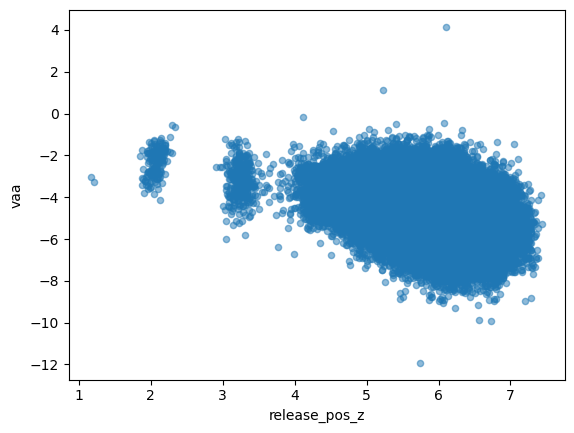

In [37]:
fastballs.plot.scatter(x="release_pos_z", y="vaa", alpha=0.5)

plt.show()


In [38]:
# get the count of each release slot by player
tt = pd.pivot_table(fastballs,index = 'player_name', columns = 'rel_pos_z_bin',values = 'pfx_z', aggfunc = 'count')
tt = tt.reset_index()
tt = tt.set_index('player_name')

#create the percentile table
tt_percent = tt.div(tt.sum(axis = 1), axis = 0)
tt_percent =tt_percent.reset_index()
tt_percent

#create table that only keeps the most frequently used release point slot
ttt = tt_percent.drop('player_name', axis =1)
ttt = ttt.idxmax(axis = 1)

#list with just player names
pname = tt_percent.iloc[:,0]

#recreate the dataframe
release_slot = pd.DataFrame(
                            {'player_name': pname,
                           'rel_pos_z_bin': ttt
                            })

#aggregate the slot average
release_slot = pd.merge(release_slot,qq,on='rel_pos_z_bin',how = 'left')
release_slot = release_slot.rename(columns ={'pfx_z': 'slot_pfx_z'})

#aggregate the player average
release_slot = pd.merge(release_slot,zz,on='player_name',how = 'left')
release_slot = release_slot.rename(columns ={'pfx_z': 'player_pfx_z'})

#aggregate the VAA slot AVERAGE
release_slot = pd.merge(release_slot, mm, on = 'rel_pos_z_bin', how = 'left')
release_slot = release_slot.rename(columns ={'vaa': 'slot_vaa'})

#aggregate the VAA PLAYER AVERAGE
release_slot = pd.merge(release_slot, ll, on = 'player_name', how = 'left')
release_slot = release_slot.rename(columns ={'vaa': 'player_vaa'})
                        
release_slot['pfx_z_OAA'] = release_slot['player_pfx_z']/release_slot['slot_pfx_z'] - 1
release_slot['vaa_OAA'] = (release_slot['player_vaa']/release_slot['slot_vaa'] - 1)*-1
release_slot = release_slot.sort_values(by='vaa_OAA', ascending = False)

In [18]:
release_slot.head(5)

,player_name,rel_pos_z_bin,slot_pfx_z,player_pfx_z,slot_vaa,player_vaa,pfx_z_OAA,vaa_OAA
341,"Loáisiga, Jonathan","(5.5, 5.75]",1.289951,1.470000,-4.639229,-3.042473,0.139578,0.344186
631,"Whitlock, Garrett","(5.75, 6.0]",1.344683,1.208333,-4.789183,-3.291263,-0.101399,0.312772
307,"King, John","(5.5, 5.75]",1.289951,0.785000,-4.639229,-3.311968,-0.391450,0.286095
296,"Kelly, Kevin","(4.25, 4.5]",0.976455,1.112000,-3.710331,-2.725367,0.138813,0.265465
380,"Mejía, J.C.","(5.5, 5.75]",1.289951,1.060000,-4.639229,-3.502965,-0.178263,0.244925


In [48]:
#find a specific player
choose_player = 'Bradley, Taj'

release_slot.loc[release_slot['player_name'] == choose_player]

,player_name,rel_pos_z_bin,slot_pfx_z,player_pfx_z,slot_vaa,player_vaa,pfx_z_OAA,vaa_OAA
64,"Bradley, Taj","(6.0, 6.25]",16.43397,19.055523,-4.990377,-4.643673,0.15952,0.069474


In [193]:
#find above average players

x = len(release_slot)

a1 = []
a2 = []
a3 = []
a4 = []
a5 = []
a6 = []

for i in range(len(release_slot)):
    
    name = release_slot.loc[i,'player_name']
    pfxPlus = release_slot.loc[i,'pfx_z_OAA']
    vaaPlus = release_slot.loc[i,'vaa_OAA']
    binn = release_slot.loc[i,'rel_pos_z_bin']
    pfx = release_slot.loc[i,'player_pfx_z']
    vaa = release_slot.loc[i,'player_vaa']
    
    if pfxPlus > 0 and vaaPlus > 0:  
        a1.append(name)
        a2.append(pfxPlus)
        a3.append(pfx)
        a4.append(vaaPlus)
        a5.append(vaa)
        a6.append(binn)
        
OAA =    pd.DataFrame({
                            'player_name': a1,
                           'pfx_OAA': a2,
                            'pfx': a3,
                            'vaa_OAA': a4,
                            'vaa': a5,
                            'release_bin': a6
                            })

OAA['sumPlus'] = OAA['pfx_OAA'] + OAA['vaa_OAA']
OAA = OAA.sort_values(by = 'sumPlus', ascending = False)
OAA = pd.merge(OAA,vv,on = 'player_name',how = 'left')

In [194]:
OAA.to_excel(directory + 'fb_OAA.xlsx')

In [49]:
x = pd.pivot_table(fastballs, index='vaa_bin',columns = 'velo_bin', values = 'swstr', aggfunc = 'mean'
                   ,fill_value = 0)
#x = x.reset_index()
#x
x


velo_bin,"(0, 90]","(90, 91]","(91, 92]","(92, 93]","(93, 94]","(94, 95]","(95, 96]","(96, 97]","(97, 98]","(98, 110]"
vaa_bin,,,,,,,,,,
"(-6.0, -5.75]",0.041584,0.042827,0.046366,0.046689,0.037764,0.037131,0.033673,0.032624,0.036946,0.030488
"(-5.75, -5.5]",0.062992,0.045788,0.052798,0.054035,0.059317,0.053560,0.050469,0.043728,0.056795,0.050607
"(-5.5, -5.25]",0.061920,0.058824,0.058770,0.059301,0.061614,0.063950,0.069982,0.067767,0.059211,0.070812
"(-5.25, -5.0]",0.075758,0.065421,0.072250,0.094232,0.083969,0.085182,0.091095,0.083396,0.099387,0.133425
"(-5.0, -4.75]",0.098160,0.085843,0.096951,0.123009,0.088564,0.098507,0.114746,0.113715,0.127451,0.113842
"(-4.75, -4.5]",0.114148,0.077961,0.127182,0.121448,0.125988,0.141245,0.135096,0.145925,0.142857,0.188264
"(-4.5, -4.25]",0.122047,0.118705,0.110083,0.115239,0.139822,0.161953,0.159182,0.165091,0.193694,0.210790
"(-4.25, -4.0]",0.102564,0.119608,0.132275,0.137955,0.152725,0.164187,0.165064,0.201273,0.198710,0.252266
"(-4.0, -3.75]",0.115819,0.117647,0.136000,0.148819,0.165673,0.181159,0.184446,0.221110,0.239819,0.260656


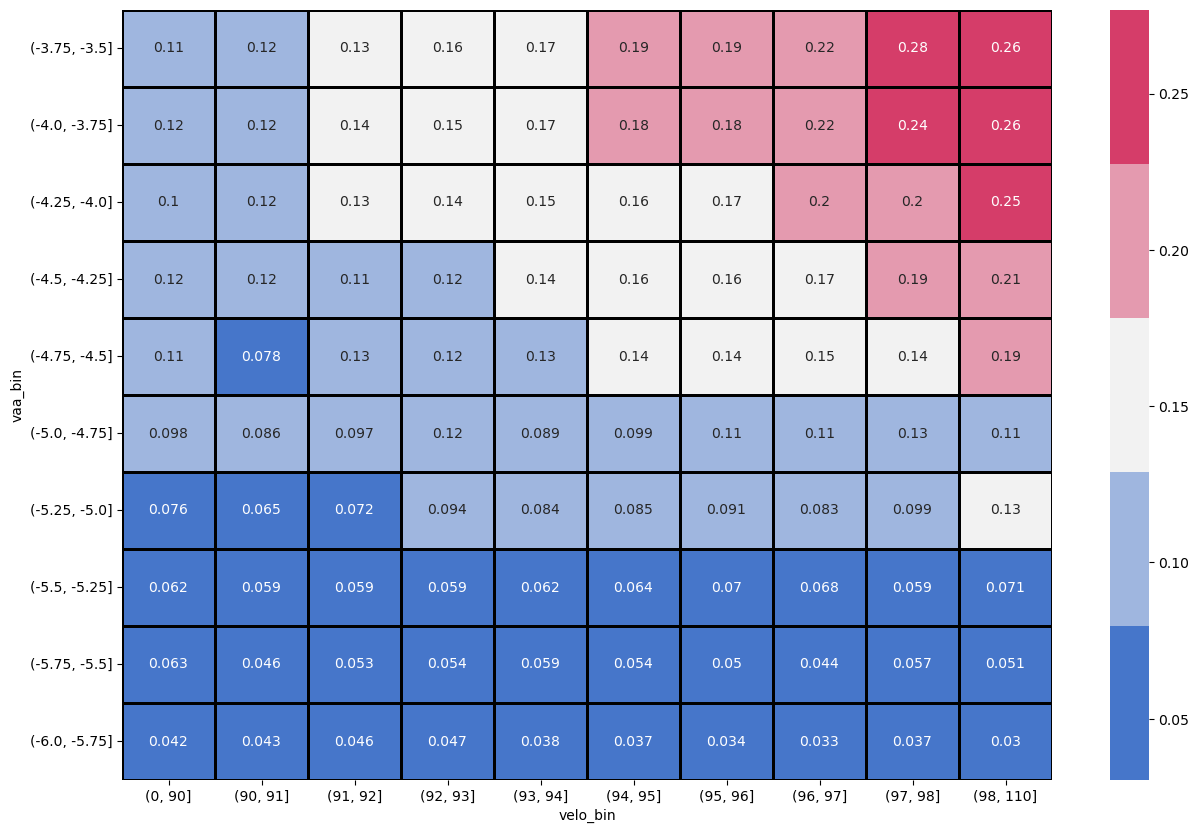

In [50]:
#fastballs['rel_pos_z_bin'] = pd.cut(fastballs['release_pos_z'], bins = rel_pos_z)
#fastballs['velo_bin'] = pd.cut(fastballs['release_speed'],bins = cut_bins_velo)
#fastballs['plate_z_bin'] = pd.cut(fastballs['plate_z'], bins = vert_sz_bins)
##fastballs['plate_x_bin'] = pd.cut(fastballs['plate_x'], bins = hor_sz_bins)
#fastballs['pfx_z_bin'] = pd.cut(fastballs['pfx_z'],bins = cut_bins_pfz)
#fastballs['vaa_bin'] = pd.cut(fastballs['vaa'], bins = vaa_bins)

from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize = (15,10))

cmap = sns.diverging_palette(255,0, sep = 10,n=5)

g = sns.heatmap(x, cmap = cmap, linewidths = 1, linecolor = 'black', annot = True)
g.invert_yaxis()
#g.add_patch(Rectangle((6,5),6,8, fill= False, edgecolor = 'black', lw = 5))
